In [27]:
import numpy as np
import itertools
from random import shuffle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
import pandas as pd

In [28]:
def padding_boxes(box, max_boxes):
    box = np.array(box)
    padded = np.concatenate([box,np.zeros((max_boxes-len(box),3))])
    return padded

def random_action_idx(f_upleft):
    if len(f_upleft) == 0: return -1
    else: return np.random.choice(range(len(f_upleft)),1)[0]

In [29]:
def f_upleft_low(f_upleft,history):
    if len(f_upleft)==0: return f_upleft
    f_h = history[f_upleft[:,0],f_upleft[:,1]]
    if np.min(f_h) == np.max(f_h): return f_upleft
    else:
        f_upleft1 = f_upleft[f_h != np.max(f_h)]
        f_h1 = history[f_upleft1[:,0],f_upleft1[:,1]]
        if np.min(f_h1) == np.max(f_h1): return f_upleft
        else:
            f_upleft2 = f_upleft[f_h != np.max(f_h)]
            return f_upleft2

In [30]:
def cbn_select_boxes(boxes, k=5):
    s_boxes = np.array(list(itertools.combinations(boxes , k)))
    s_boxes = np.unique(s_boxes, axis=0)
    return s_boxes

In [31]:
def idx_to_order(idx, K):
    order_list = list(itertools.permutations(range(K)))
    order = order_list[idx]
    order = list(order)
    return order

In [32]:
def get_remain(s_boxes, r_boxes):
    for i in s_boxes:
        if i in r_boxes:
            drop_idx = np.where(np.all(i==r_boxes,axis=1))[0][0]
            r_boxes = np.delete(r_boxes, (drop_idx), axis=0)
    return r_boxes

In [33]:
def raw_to_input(container, s_order, r_boxes, num_max_remain): # K, 
    # input (L, B), (N, k, 3), (N, num_max_remain, 3)
    # return (N, L*B), (N, k, 3), (N, num_max_remain, 3), N은 조합*순열 수
    #  s_order = np.array(s_order)/20, 
    container = np.array([container]*len(s_order)).reshape((-1, 20,20,1))
    r_boxes = np.array([padding_boxes(get_remain(s_boxes, r_boxes), num_max_remain) for s_boxes in s_order]) #(N, num_max_remain, 3)
    # s_order = np.array([padding_boxes(s_boxes, K) for s_boxes in s_order])
    # s_order = s_order.astype('int')
    container,r_boxes = np.array(container)/20, np.array(r_boxes)/20 #scaline
    return container, r_boxes #s_order, 

In [34]:
def get_f_upleft(box, env):
    # 모든 가능한 적재 위치
    state = env.container_h.copy()
    env_l, env_b, env_h = env.length, env.breadth, env.height
    bxl, bxb, bxh = box[0], box[1], box[2]
    f_loc = np.where(state != env_h) # 환경의 높이보다 state 작은 위치
    f_upleft = np.array([[i,j] for i,j in zip(f_loc[0], f_loc[1])])
    f_upleft = f_upleft.astype('int')
    if len(f_upleft) > 0:
        f_upleft = f_upleft[f_upleft[:,0] + bxl  <= env_l ] # row 넘어가면 삭제
        f_upleft = f_upleft[f_upleft[:,1] + bxb <= env_b ] # columns 넘어가면 삭제
        drop_idx = [] # 높이 넘어가면 삭제
        for i,[j,k] in enumerate(f_upleft):
            if np.sum(state[j:j+bxl,k:k+bxb] + bxh > env_h) >0: drop_idx.append(i)
        f_upleft=np.delete(f_upleft,drop_idx,axis=0)        
    return f_upleft

In [35]:
def get_locxyz(f_upleft, state):
    # 위치와 해당 높이 반환
    z_coord = np.array([state[i,j] for i,j in f_upleft])
    loc_xyz = np.concatenate([f_upleft, z_coord[:,np.newaxis]], axis=1)
    return loc_xyz

In [36]:
def fixed_pos(loc_xyz):
    # 가장 (1)낮은 heigth, (2)낮은 row, (3)낮은 columns
    loc_xyz = loc_xyz[np.lexsort((loc_xyz[:,1],loc_xyz[:,0],loc_xyz[:,2]))]
    loc_xyz = loc_xyz[0].astype('int')
    return loc_xyz

In [37]:
def get_selected_order(selected, k):
    selected_order = []
    perm_idx = list(itertools.permutations(range(k)))
    for s in selected:
        for i in range(len(perm_idx)):
            p = perm_idx[i] # 순서 선택
            selected_order.append( s[list(p)] )
    selected_order = np.stack(selected_order)
    selected_order = np.unique(selected_order, axis=0)
    return selected_order 

In [38]:
def get_selected_location(s_order, pred_pos_org, used_boxes_org, state_org):
    # 정해진 순서에 따라 하나씩 적재
    s_locs, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c  = [],[],[],[],[]
    next_cube_c = []
    for boxes in s_order:
        env = Bpp3DEnv()
        state = state_org.copy()
        next_state = np.zeros((20,20))
        env.convert_state(state)
        pred_pos = pred_pos_org.copy()
        used_boxes = used_boxes_org.copy()
        num_loaded_box = 0
        s_loc = np.zeros((20,20,20))
        for box in boxes:
            if np.sum(box)==0:
                f_upleft = []
            else:
                f_upleft = get_f_upleft(box, env)
            if len(f_upleft) == 0:
                continue
            xyz = get_locxyz(f_upleft, env.container_h) #높이 반환
            fixted_xyz = fixed_pos(xyz) # 가능한 적재 위치 중 하나 선택
            xy = fixted_xyz[:2].astype('int')
            next_state = env.step(xy,box[0],box[1],box[2]).copy()########################
            num_loaded_box += 1
            pred_pos.append(fixted_xyz)
            used_boxes.append(box)
            # location
            x,y,z = fixted_xyz.astype('int')
            l,b,h = box
            s_loc[x:x+l, y:y+b, z:z+h] = 1
            
        s_locs.append(s_loc)
        pred_pos_c.append(pred_pos)
        used_boxes_c.append(used_boxes)
        #next_state_c.append(next_state) #############################
        next_state_h = env.update_h().copy()
        next_state_c.append(next_state_h)
        next_cube = env.container.copy()
        next_cube_c.append(next_cube)
        num_loaded_box_c.append(num_loaded_box)
        
    s_locs = np.stack(s_locs) #(N, 20,20,20)
    # fig = plt.figure()
    # ax = fig.gca(projection='3d')
    # ax.set_aspect('auto')
    # ax.voxels(s_locs[1], edgecolor="k")
    # plt.show()
    return s_locs, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c

In [39]:
class Bpp3DEnv():#(gym.Env):
    #metadata = {'render.modes': ['human']}
    #
    def __init__(self,length=20, breadth=20, height=20):
        super(Bpp3DEnv, self).__init__()
        self.length=length
        self.breadth=breadth
        self.height=height
        self.container_h=np.zeros((self.length,self.breadth))
        self.container=np.zeros((self.length, self.breadth, self.height))
    
    def update_h(self):
        idx = np.where(self.container == 1)
        h = pd.DataFrame(np.transpose(idx, (1,0)))
        h.columns = ['0','1','2']
        h = h.groupby(['0','1']).agg({'0':'first','1':'first','2':'max'}).values
        self.reset_h()
        self.container_h[h[:,0],h[:,1]] = h[:,2]+1
        return self.container_h
    
    def convert_state(self, new_container):
        self.container = new_container
        self.update_h()
    
    def next_state(self, upleft,bxl,bxb,bxh):
        next_container_h = self.container_h.copy()
        loading_area_h = self.container_h[upleft[0]:upleft[0]+bxl, upleft[1]:upleft[1]+bxb]
        max_h = np.max(loading_area_h).astype('int')
        next_container_h[upleft[0]:upleft[0]+bxl,upleft[1]:upleft[1]+bxb] = bxh + max_h
        
        next_container = self.container.copy()
        next_container[upleft[0]:upleft[0]+bxl, upleft[1]:upleft[1]+bxb, max_h:bxh + max_h] = 1
        
        return next_container, next_container_h
    
    def step(self, upleft,bxl,bxb,bxh):
        n_s, n_h = self.next_state(upleft,bxl,bxb,bxh)
        self.convert_state(n_s)
        return n_s
    
    def reset(self):
        self.container = np.zeros((self.length,self.breadth, self.height))
        self.container_h = np.zeros((self.length,self.breadth))
    
    def reset_h(self):
        self.container_h = np.zeros((self.length,self.breadth))
        
    def terminal_reward(self):
        return np.sum(self.container)/(self.length*self.breadth*self.height)
    

In [40]:
def cuboid_data2(o, size=(1,1,1)):
    X = [[[0, 1, 0], [0, 0, 0], [1, 0, 0], [1, 1, 0]],
         [[0, 0, 0], [0, 0, 1], [1, 0, 1], [1, 0, 0]],
         [[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1]],
         [[0, 0, 1], [0, 0, 0], [0, 1, 0], [0, 1, 1]],
         [[0, 1, 0], [0, 1, 1], [1, 1, 1], [1, 1, 0]],
         [[0, 1, 1], [0, 0, 1], [1, 0, 1], [1, 1, 1]]]
    X = np.array(X).astype(float)
    for i in range(3):
        X[:,:,i] *= size[i]
    X += np.array(o)
    return X

def plotCubeAt2(positions,sizes=None,colors=None, **kwargs):
    if not isinstance(colors,(list,np.ndarray)): colors=["C0"]*len(positions)
    if not isinstance(sizes,(list,np.ndarray)): sizes=[(1,1,1)]*len(positions)
    g = []
    for p,s,c in zip(positions,sizes,colors):
        g.append( cuboid_data2(p, size=s) )
    return Poly3DCollection(np.concatenate(g),facecolors=np.repeat(colors,6), alpha=0.5, **kwargs)

def get_colors(n_box):
    color_names=["crimson","limegreen","grey","brown","orange","olive","blue","purple","yellow","pink","skyblue","red","aqua","gold"]
    colors = color_names*(n_box//len(color_names))+color_names[:n_box%len(color_names)]
    return colors

def vis_box(sizes,positions,fs=(10,5), title=''):
    colors = get_colors(len(positions))
    plt.figure('SPLTV', figsize=(15,5))
    #ax = fig.gca(projection='3d')
    ax = plt.subplot(141, projection='3d')
    #ax.set_aspect('auto')
    plt.title(title)
    #ax.subplot(sub[0],sub[1],sub[2],projection='3d')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    ax = plt.subplot(142,projection='3d')
    plt.title(title + '(z)')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(90,-90)
    
    ax = plt.subplot(143,projection='3d')
    plt.title(title + '(x)')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(0,0)
    
    ax = plt.subplot(144,projection='3d')
    plt.title(title + '(y)')
    pc = plotCubeAt2(positions,sizes,colors=colors, edgecolor="w")
    ax.add_collection3d(pc)    
    ax.set_xlim([0,20])
    ax.set_ylim([0,20])
    ax.set_zlim([0,20])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.view_init(0,-90)
    
    plt.show()

In [44]:
import numpy as np
from random import shuffle
from itertools import chain, combinations
from itertools import compress

def powerset(iterable):
    subset_list = list(chain.from_iterable(combinations(iterable, r) for r in range(1,len(iterable)+1)))
    return [list(i) for i in subset_list]

def find_factor(n):
    factor_values = []
    for i in range(1, n + 1):
        if n % i == 0:
            factor_values.append(i)

    values = []
    for v in factor_values:
        values.append(v)

    return values[1:-1]

def divide_uniform(pop_item, position, axis_idx,n_div,is_factors=False):
    # 나뉜 size 계산
    if is_factors: size_list = [(pop_item[axis_idx])//n_div]*n_div
    else:    
        size_list = []
        for i in range(n_div-1):
            if i == 0 : size_list.append((pop_item[axis_idx])//(n_div-i))
            else: size_list.append((pop_item[axis_idx] - size_list[-1])//(n_div-i))
        size_list.append(pop_item[axis_idx] - np.sum(size_list))
    # size와 position 계산
    sizes, positions = [],[] 
    for i in range(n_div):
        #size
        item = pop_item.copy()
        item[axis_idx] = size_list[i]
        sizes.append(item)
        #position
        new_position = position.copy()
        if i!=0: new_position[axis_idx] += int(np.sum(size_list[:i]))
        positions.append(new_position)
    return sizes,positions

def divide_uniform_multi_axis(item_size, item_pos, axis_idx_list,n_div,is_factors=False):
    item_size = [item_size]; item_pos = [item_pos]
    for axis_idx in axis_idx_list:
        n=len(item_size)
        sizes,positions = [],[]
        for i in range(n):
            size = item_size.pop()
            pos = item_pos.pop()
            size, pos = divide_uniform(size, pos , axis_idx, n_div,is_factors)
            sizes += size
            positions += pos
        item_size = sizes.copy()
        item_pos = positions.copy()
    return sizes, positions

def generation_3dbox(case_size=[[20,20,20],[25,20,15]], N_mdd=20, min_s = 3, is_prediv=0):
    #c_l, c_b, c_h: length, breadth, height
    case_input=[]
    case_gt_upleft=[]
    for c_l,c_b,c_h in case_size:
        if type(N_mdd)==tuple: np.random.choice(list(range(N_mdd[0],N_mdd[1])), 1)#N_mdd = 20 # 
        X_input=[[c_l,c_b,c_h]]
        gt_upleft=[[0,0,0]]

        if is_prediv==8: #8분할
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [0,1,2],2)
        elif is_prediv == 4:#4분할
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [0,1],2)
        elif is_prediv == 'h': #높이 분할
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [2],3)
        elif is_prediv == '4h':
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [2],3)
            for i in range(3):
                sizes, positions = divide_uniform_multi_axis(X_input.pop(0), gt_upleft.pop(0), [0,1],2)
                X_input+=sizes;gt_upleft+=positions
        elif is_prediv == '2h':
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [2],3)
            for i in range(3):
                sizes, positions = divide_uniform_multi_axis(X_input.pop(0), gt_upleft.pop(0), [0],2)
                X_input+=sizes;gt_upleft+=positions
                
        while(len(X_input)<N_mdd):
            idx=np.random.choice(range(len(X_input)), 1)[0]
            pop_item=X_input.pop(idx)#[l, b, h]
            pop_gt_upleft=gt_upleft.pop(idx)
            axis_idx = np.random.choice([0,1,2],1)[0]
            factors = find_factor(pop_item[axis_idx])
            factors = list(compress(factors, pop_item[axis_idx]/np.array(factors) >=3))
            if pop_item[axis_idx] < min_s*2 or len(factors)==0:
                X_input.append(pop_item)
                gt_upleft.append(pop_gt_upleft)
            else:
                n_div = np.random.choice(factors,1)[0]
                if False:
                    axis_idx_list = []
                    for i in range(3):
                        if pop_item[idx]==pop_item[i]: axis_idx_list.append(i)
                    axis_idx_list = powerset(axis_idx_list)
                    axis_idx_list =list(compress(axis_idx_list, [idx in i for i in axis_idx_list]))
                    axis_idx_list = axis_idx_list[np.random.choice(len(axis_idx_list),1)[0]]
                axis_idx_list = [axis_idx]
                #sizes, positions = divide_uniform_multi_axis(pop_item, pop_gt_upleft, axis_idx_list, n_div)
                #sizes, positions = divide_uniform(pop_item, pop_gt_upleft, idx, n_div)
                sizes, positions = divide_uniform_multi_axis(pop_item, pop_gt_upleft, axis_idx_list, n_div,is_factors=True)
                X_input+=sizes;gt_upleft+=positions
        #무게 포함
        #mdd_w=np.random.uniform(low=5.0, high=18.0, size=N_mdd)
        #X_input=[list(a[0] + [a[1]]) for a in zip(X_input,mdd_w)]

        #순서 -> 랜덤 정렬 (single)
        #z = list(zip(X_input, gt_upleft))
        #shuffle(z)
        #X_input, gt_upleft = zip(*z)
           
        #순서 -> 크기순 정렬
        #s=[i*j*q for i,j,q in X_input]
        #s_idx=sorted(range(len(s)), key=lambda k: s[k])
        #X_input=np.array(X_input)[list(reversed(s_idx))]
        #gt_upleft=np.array(gt_upleft)[list(reversed(s_idx))]

        #순서 -> 아래부터 정렬
        idx = np.argsort(np.array(gt_upleft)[:,2])
        gt_upleft = np.array(gt_upleft)[idx]
        X_input = np.array(X_input)[idx]

        case_input.append(X_input)
        case_gt_upleft.append(gt_upleft)
    return case_input,case_gt_upleft



def generation_3dbox_random(case_size=[[20,20,20],[25,20,15]],min_s = 3, is_prediv=0, N_mdd=22):
    #c_l, c_b, c_h: length, breadth, height
    #np.random.seed(seed=100)
    case_input=[]
    case_gt_upleft=[]
    
    for c_l,c_b,c_h in case_size:
        #N_mdd=22#12#np.random.choice(list(range(23,28)), 1)

        X_input=[[c_l,c_b,c_h]]
        gt_upleft=[[0,0,0]]
        
        if is_prediv==8: #8분할
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [0,1,2],2)
            
        elif is_prediv == 4:#4분할
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [0,1],2)
            
        elif is_prediv == 'h': #높이 분할
            X_input, gt_upleft = divide_uniform_multi_axis(X_input.pop(), gt_upleft.pop(), [2],3)
        
        while(len(X_input)<N_mdd):
            idx=np.random.choice(range(len(X_input)), 1)[0]#pop an item randomly from X_input
            pop_item=X_input.pop(idx)#[l, b, h]
            pop_gt_upleft=gt_upleft.pop(idx)
            idx=np.random.choice([0,1,2],1)[0]#choose an axis randomly
            if pop_item[idx] < min_s*2:
                X_input.append(pop_item)
                gt_upleft.append(pop_gt_upleft)
            else:#item split
                pos=np.random.choice(list(range(min_s,pop_item[idx]+1-min_s)),1)[0]#choose a position randomly - distance
                #item
                item1=pop_item.copy()
                item2=pop_item.copy()
                item1[idx]=pos
                item2[idx]=pop_item[idx]-pos
                X_input+=[item1,item2]
                #gt upleft
                itme2_upleft=pop_gt_upleft.copy()
                itme2_upleft[idx] += pos
                gt_upleft+=[pop_gt_upleft,itme2_upleft]
                   
        #무게 포함
        #mdd_w=np.random.uniform(low=5.0, high=18.0, size=N_mdd)
        #X_input=[list(a[0] + [a[1]]) for a in zip(X_input,mdd_w)]

        #순서 -> 랜덤 정렬
        #z = list(zip(X_input, gt_upleft))
        #shuffle(z)
        #X_input, gt_upleft = zip(*z)

        #순서 -> 크기순 정렬
        #s=[i*j*q for i,j,q in X_input]
        #s_idx=sorted(range(len(s)), key=lambda k: s[k])
        #X_input=np.array(X_input)[list(reversed(s_idx))]
        #gt_upleft=np.array(gt_upleft)[list(reversed(s_idx))]
        
        #순서 -> 아래부터 정렬
        idx = np.argsort(np.array(gt_upleft)[:,2])
        gt_upleft = np.array(gt_upleft)[idx]
        X_input = np.array(X_input)[idx]
        
        
        case_input.append(X_input)
        case_gt_upleft.append(gt_upleft)
    return case_input,case_gt_upleft

혜숙선배처럼 cnn으로 state 예측하고
그거갖고 actor, critic 만들기

In [41]:
from libs.generate_boxes import *

In [58]:
N_MDD = 5
K = 3
n_candidates = 4

In [59]:
boxes, gt_pos = generation_3dbox_random(case_size=[[20,20,20]],min_s=1,N_mdd=N_MDD)
boxes, gt_pos

([array([[17, 20, 20],
         [ 1, 15, 20],
         [ 1,  5, 20],
         [ 2, 20, 15],
         [ 2, 20,  5]])],
 [array([[ 1,  0,  0],
         [ 0,  0,  0],
         [ 0, 15,  0],
         [18,  0,  0],
         [18,  0, 15]])])

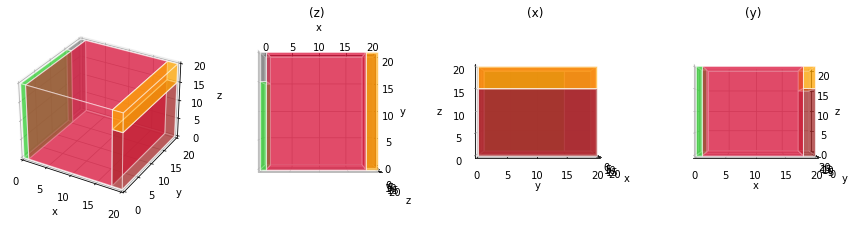

In [60]:
vis_box(boxes[0], gt_pos[0])

In [61]:
num_max_boxes = len(boxes[0])
num_max_remain = num_max_boxes - K
num_max_boxes, num_max_remain

(5, 2)

In [62]:
env = Bpp3DEnv()
env.reset()
step = 0

r_boxes = np.array(np.array(boxes)[0].copy())
r_boxes

array([[17, 20, 20],
       [ 1, 15, 20],
       [ 1,  5, 20],
       [ 2, 20, 15],
       [ 2, 20,  5]])

In [63]:
state = env.container.copy()
k = min(K, len(r_boxes))
k

3

In [93]:
state.shape

(20, 20, 20)

In [88]:
r_boxes[:n_candidates]

array([[17, 20, 20],
       [ 1, 15, 20],
       [ 1,  5, 20],
       [ 2, 20, 15]])

In [86]:
step += 1
selected = cbn_select_boxes(r_boxes[:n_candidates], k)
selected.shape, selected

((4, 3, 3),
 array([[[ 1, 15, 20],
         [ 1,  5, 20],
         [ 2, 20, 15]],
 
        [[17, 20, 20],
         [ 1,  5, 20],
         [ 2, 20, 15]],
 
        [[17, 20, 20],
         [ 1, 15, 20],
         [ 1,  5, 20]],
 
        [[17, 20, 20],
         [ 1, 15, 20],
         [ 2, 20, 15]]]))

In [90]:
list(itertools.permutations(range(k)))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]

In [91]:
s_order = get_selected_order(selected, k)
s_order.shape, s_order

((24, 3, 3),
 array([[[ 1,  5, 20],
         [ 1, 15, 20],
         [ 2, 20, 15]],
 
        [[ 1,  5, 20],
         [ 1, 15, 20],
         [17, 20, 20]],
 
        [[ 1,  5, 20],
         [ 2, 20, 15],
         [ 1, 15, 20]],
 
        [[ 1,  5, 20],
         [ 2, 20, 15],
         [17, 20, 20]],
 
        [[ 1,  5, 20],
         [17, 20, 20],
         [ 1, 15, 20]],
 
        [[ 1,  5, 20],
         [17, 20, 20],
         [ 2, 20, 15]],
 
        [[ 1, 15, 20],
         [ 1,  5, 20],
         [ 2, 20, 15]],
 
        [[ 1, 15, 20],
         [ 1,  5, 20],
         [17, 20, 20]],
 
        [[ 1, 15, 20],
         [ 2, 20, 15],
         [ 1,  5, 20]],
 
        [[ 1, 15, 20],
         [ 2, 20, 15],
         [17, 20, 20]],
 
        [[ 1, 15, 20],
         [17, 20, 20],
         [ 1,  5, 20]],
 
        [[ 1, 15, 20],
         [17, 20, 20],
         [ 2, 20, 15]],
 
        [[ 2, 20, 15],
         [ 1,  5, 20],
         [ 1, 15, 20]],
 
        [[ 2, 20, 15],
         [ 1,  5, 20],
     

In [66]:
state_h = env.update_h().copy()
state_h

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.

In [67]:
in_state, in_r_boxes = raw_to_input(state_h, s_order, r_boxes, num_max_remain)
in_state, in_r_boxes

(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [95]:
in_r_boxes * 20

array([[[17., 20., 20.],
        [ 2., 20.,  5.]],

       [[ 2., 20., 15.],
        [ 2., 20.,  5.]],

       [[17., 20., 20.],
        [ 2., 20.,  5.]],

       [[ 1., 15., 20.],
        [ 2., 20.,  5.]],

       [[ 2., 20., 15.],
        [ 2., 20.,  5.]],

       [[ 1., 15., 20.],
        [ 2., 20.,  5.]],

       [[17., 20., 20.],
        [ 2., 20.,  5.]],

       [[ 2., 20., 15.],
        [ 2., 20.,  5.]],

       [[17., 20., 20.],
        [ 2., 20.,  5.]],

       [[ 1.,  5., 20.],
        [ 2., 20.,  5.]],

       [[ 2., 20., 15.],
        [ 2., 20.,  5.]],

       [[ 1.,  5., 20.],
        [ 2., 20.,  5.]],

       [[17., 20., 20.],
        [ 2., 20.,  5.]],

       [[ 1., 15., 20.],
        [ 2., 20.,  5.]],

       [[17., 20., 20.],
        [ 2., 20.,  5.]],

       [[ 1.,  5., 20.],
        [ 2., 20.,  5.]],

       [[ 1., 15., 20.],
        [ 2., 20.,  5.]],

       [[ 1.,  5., 20.],
        [ 2., 20.,  5.]],

       [[ 2., 20., 15.],
        [ 2., 20.,  5.]],

       [[ 1.

In [68]:
pred_pos, used_boxes = [], []

In [69]:
s_loc_c, pred_pos_c, used_boxes_c, next_state_c, num_loaded_box_c, next_cube_c = get_selected_location(s_order, pred_pos, used_boxes, state)

In [70]:
s_loc_c

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],

        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
    

In [71]:
pred_pos_c

[[array([0, 0, 0]), array([0, 5, 0]), array([1, 0, 0])],
 [array([0, 0, 0]), array([0, 5, 0]), array([1, 0, 0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([0, 5, 0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([3, 0, 0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([0, 5, 0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([18,  0,  0])],
 [array([0, 0, 0]), array([ 0, 15,  0]), array([1, 0, 0])],
 [array([0, 0, 0]), array([ 0, 15,  0]), array([1, 0, 0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([ 0, 15,  0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([3, 0, 0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([ 0, 15,  0])],
 [array([0, 0, 0]), array([1, 0, 0]), array([18,  0,  0])],
 [array([0, 0, 0]), array([2, 0, 0]), array([2, 5, 0])],
 [array([0, 0, 0]), array([2, 0, 0]), array([3, 0, 0])],
 [array([0, 0, 0]), array([2, 0, 0]), array([ 2, 15,  0])],
 [array([0, 0, 0]), array([2, 0, 0]), array([3, 0, 0])],
 [array([0, 0, 0]), array([2, 0, 0]), array([19,  0,  0])],
 [array

In [72]:
used_boxes_c

[[array([ 1,  5, 20]), array([ 1, 15, 20]), array([ 2, 20, 15])],
 [array([ 1,  5, 20]), array([ 1, 15, 20]), array([17, 20, 20])],
 [array([ 1,  5, 20]), array([ 2, 20, 15]), array([ 1, 15, 20])],
 [array([ 1,  5, 20]), array([ 2, 20, 15]), array([17, 20, 20])],
 [array([ 1,  5, 20]), array([17, 20, 20]), array([ 1, 15, 20])],
 [array([ 1,  5, 20]), array([17, 20, 20]), array([ 2, 20, 15])],
 [array([ 1, 15, 20]), array([ 1,  5, 20]), array([ 2, 20, 15])],
 [array([ 1, 15, 20]), array([ 1,  5, 20]), array([17, 20, 20])],
 [array([ 1, 15, 20]), array([ 2, 20, 15]), array([ 1,  5, 20])],
 [array([ 1, 15, 20]), array([ 2, 20, 15]), array([17, 20, 20])],
 [array([ 1, 15, 20]), array([17, 20, 20]), array([ 1,  5, 20])],
 [array([ 1, 15, 20]), array([17, 20, 20]), array([ 2, 20, 15])],
 [array([ 2, 20, 15]), array([ 1,  5, 20]), array([ 1, 15, 20])],
 [array([ 2, 20, 15]), array([ 1,  5, 20]), array([17, 20, 20])],
 [array([ 2, 20, 15]), array([ 1, 15, 20]), array([ 1,  5, 20])],
 [array([ 

In [73]:
next_state_c

[array([[20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20., 20.,
         20., 20., 20., 20., 20., 20., 20.],
        [15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
         15., 15., 15., 15., 15., 15., 15.],
        [15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15., 15.,
         15., 15., 15., 15., 15., 15., 15.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,

In [74]:
num_loaded_box_c

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [75]:
next_cube_c

[array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],
 
        [[1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         ...,
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.],
         [1., 1., 1., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],


In [77]:
in_state, s_loc_c, in_r_boxes

(array([[[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         ...,
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]],
 
 
        [[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]],
 
         [[0.],
          [0.],
          [0.],
          ...,
      

In [78]:
in_state.shape

(24, 20, 20, 1)

In [79]:
s_loc_c.shape

(24, 20, 20, 20)

In [80]:
in_r_boxes.shape

(24, 2, 3)

In [97]:
in_state.shape, s_loc_c.shape, in_r_boxes.shape

((24, 20, 20, 1), (24, 20, 20, 20), (24, 2, 3))

In [ ]:
24,144 24,144 24,64 24,1